In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/best

/alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/best


/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [4]:
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

### Создадим агрегатор

In [5]:
from src.aggregate.base import Aggregator, ComposeClassifier
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.noborder import NoBorderClassifier
from src.aggregate.confidence import MaxConfidenceClassifier, ConfidenceClassifier
from src.aggregate.merge import UnionMerger, NMSMerger, SoftNMSMerger

In [6]:
N_CLASSES = 2
INTEGRATE_THRESHOLD = 1
IMAGE_SHAPE = (1000, 1000)

In [ ]:
input_conf_filter = ConfidenceClassifier(N_CLASSES, 0.75)
noborder_classifier = NoBorderClassifier(N_CLASSES, IMAGE_SHAPE)
threshold_classifier = ThresholdClassifier(N_CLASSES, 1)
confidence_classifier = MaxConfidenceClassifier(N_CLASSES, 0.75)

classifier = ComposeClassifier([
    input_conf_filter,
    threshold_classifier,
    confidence_classifier
])

aggregator = Aggregator(classifier, SoftNMSMerger(N_CLASSES, conf_threshold=0.5))
gt_aggregator = Aggregator(ThresholdClassifier(N_CLASSES, 1), UnionMerger(N_CLASSES))

### Интерполированный тест

In [8]:
import pickle
import json
TEST_NAME = 'dense'
with open(f'/alpha/projects/wastie/code/kondrashov/delta/notes/gt_24_12_dense_c06.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'/alpha/projects/wastie/code/kondrashov/delta/notes/pred_24_12_dense_c06.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/{TEST_NAME}_test/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

Median group size: 13


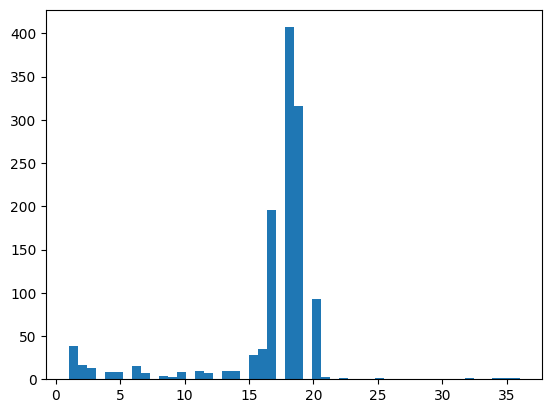

In [9]:
plt.hist([len(g) for g in gt_extended_groups], bins=50)
median_length = int(np.median([len(g) for g in pred_extended_groups]))
print(f"Median group size: {median_length}")

### Получим группы на ленте

In [10]:
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

In [11]:
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box
def make_box_from_mask(obj):
    box = get_box(obj)
    x1 = [box[0], box[1]]
    x2 = [box[0], box[3]]
    x3 = [box[2], box[3]]
    x4 = [box[2], box[1]]
    obj['points'] = np.array([x1, x2, x3, x4])
    return obj

In [12]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        conf = None
        if 'conf' in obj['obj']:
            conf = float(obj['obj']['conf'])
        obj['obj'] = shift_mask(obj['obj'], shift)
        obj['obj']['is_border'] = obj['is_border']
        if conf is not None:
            obj['obj']['conf'] = conf
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [13]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [14]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

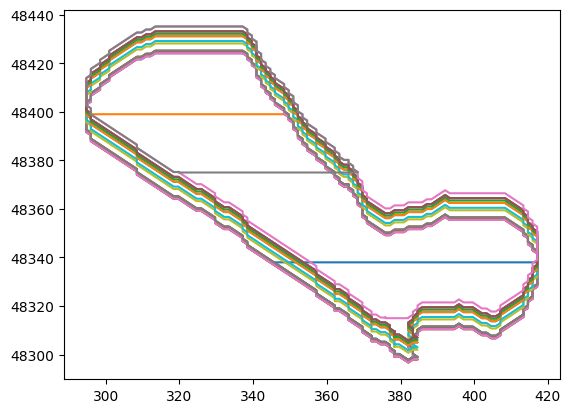

In [15]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Агрегация

In [16]:
gt = aggregator.aggregate(gt_groups)
pred = aggregator.aggregate(pred_groups)

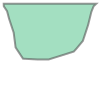

In [17]:
poly(gt[random.randint(0, len(gt))])

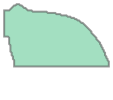

In [18]:
poly(pred[random.randint(0, len(pred))])

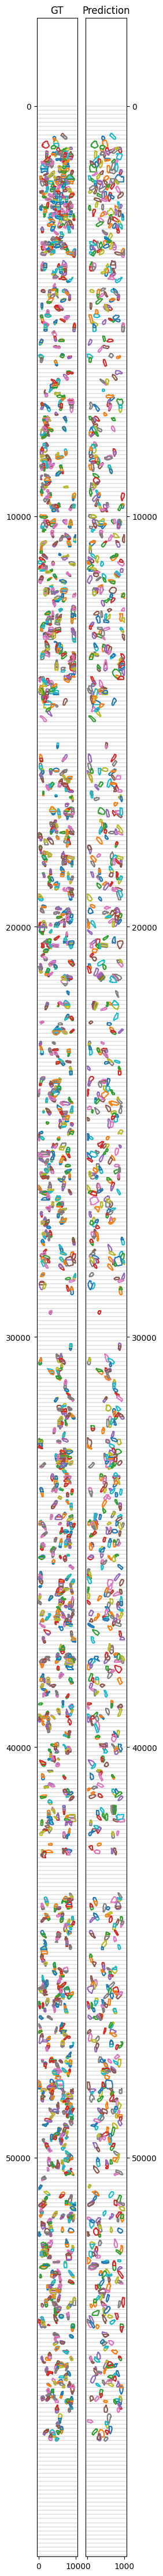

In [19]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, max(shifts.values()) / 1000))

for polygon in map(poly, gt):
    x, y = polygon.exterior.xy
    ax1.plot(x, y)
ax1.invert_yaxis()
ax1.set_title('GT')

for polygon in map(poly, pred):
    x, y = polygon.exterior.xy
    ax2.plot(x, y)
ax2.invert_yaxis()
ax2.set_title('Prediction')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

xlim = (min(ax.get_xlim()[0] for ax in [ax1, ax2]), max(ax.get_xlim()[1] for ax in [ax1, ax2]))
ylim = (min(ax.get_ylim()[0] for ax in [ax1, ax2]), max(ax.get_ylim()[1] for ax in [ax1, ax2]))

for ax in [ax1, ax2]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


min_ylim = 0
max_ylim = min(ax.get_ylim()[0] for ax in [ax1, ax2])
for ax in [ax1, ax2]:
    step = 100  # Draw line every 100 pixels
    for y in range(int(min_ylim), int(max_ylim), step):
        ax.axhline(y=y, color='gray', alpha=0.2, linestyle='-')

plt.show()

### Метрики

In [ ]:
import numpy as np
from shapely.strtree import STRtree
from shapely.geometry import Polygon, box
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing as mp

def get_box(points):
    """Вычисление ограничивающего прямоугольника для списка точек"""
    points = np.array(points)
    return [np.min(points[:, 0]), np.min(points[:, 1]), 
            np.max(points[:, 0]), np.max(points[:, 1])]

def mask_iou_from_points(gt_points, pred_points):
    """Вычисление IoU для двух масок по их точкам"""
    gt_poly = Polygon(gt_points)
    pred_poly = Polygon(pred_points)
    
    if not gt_poly.is_valid or not pred_poly.is_valid:
        return 0.0
    
    intersection = gt_poly.intersection(pred_poly).area
    union = gt_poly.union(pred_poly).area
    
    return intersection / union if union > 0 else 0.0

def process_chunk(args):
    """Обработка пакета данных для параллельных вычислений"""
    chunk, iou_threshold = args
    chunk_results = []
    for i, j, gt_points, pred_points in chunk:
        iou = mask_iou_from_points(gt_points, pred_points)
        if iou > iou_threshold:
            chunk_results.append((i, j))
    return chunk_results

def find_matches(gt: list[dict], pred: list[dict], iou_threshold: float = 0.7):
    """Поиск совпадений между GT и предсказанными масками с использованием IoU"""
    # Извлечение точек и вычисление bounding boxes
    gt = [obj for obj in gt if len(obj['points']) > 0]
    pred = [obj for obj in pred if len(obj['points']) > 0]
    gt_points_list = [np.array(obj['points']) for obj in gt]
    pred_points_list = [np.array(obj['points']) for obj in pred]
    
    gt_boxes = [get_box(points) for points in gt_points_list]
    pred_boxes = [get_box(points) for points in pred_points_list]
    
    # Создание геометрий для пространственного индекса
    gt_geoms = [box(*b) for b in gt_boxes]
    pred_geoms = [box(*b) for b in pred_boxes]
    
    # Построение пространственного индекса для быстрого поиска пересечений
    tree = STRtree(pred_geoms)
    pairs_indices = []
    
    # Поиск пересекающихся пар с использованием пространственного индекса
    for i, gt_geom in enumerate(gt_geoms):
        j_indices = tree.query(gt_geom)
        for j in j_indices:
            pairs_indices.append((i, j))
    
    # Подготовка данных для параллельной обработки
    tasks = []
    chunk_size = min(1000, max(1, len(pairs_indices) // (mp.cpu_count() * 4)))
    
    for idx in range(0, len(pairs_indices), chunk_size):
        chunk = []
        for i, j in pairs_indices[idx:idx+chunk_size]:
            chunk.append((
                i, j,
                gt_points_list[i],
                pred_points_list[j]
            ))
        tasks.append((chunk, iou_threshold))
    
    # Параллельное вычисление IoU
    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)
    
    if tasks:
        with ProcessPoolExecutor() as executor:
            results = list(tqdm(
                executor.map(process_chunk, tasks),
                total=len(tasks),
                desc="Processing pairs"
            ))
            
            for chunk_results in results:
                for i, j in chunk_results:
                    gt_matches[i] = True
                    pred_matches[j] = True
    
    return np.array(gt_matches), np.array(pred_matches)

In [21]:
gt_matches, pred_matches = find_matches(gt, pred, IOU_THRESHOLD)

  0%|                                                                                                                                                              | 0/3760 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3760/3760 [01:56<00:00, 32.32it/s]


In [22]:
gt_matches[[g['cls'] == 1 for g in gt]]

array([], dtype=bool)

In [23]:
precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.4403
Recall: 0.1654
F1 Score: 0.2405


Бутылки

In [24]:
gm, pm = gt_matches[[g['cls'] == 0 for g in gt]], pred_matches[[g['cls'] == 0 for g in pred]]
precision = np.mean(pm) if len(pm) > 0 else 0
recall = np.mean(gm) if len(gm) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print("# Bottles #")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Bottles #
Precision: 0.4403
Recall: 0.1654
F1 Score: 0.2405


In [25]:
gm, pm = gt_matches[[g['cls'] == 1 for g in gt]], pred_matches[[g['cls'] == 1 for g in pred]]
precision = np.mean(pm) if len(pm) > 0 else 0
recall = np.mean(gm) if len(gm) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print("# Bottles #")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Bottles #
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


### Оптимальный порог интеграции

In [26]:
def find_best_threshold(gt_aligned_groups, pred_aligned_groups):
    thresholds = range(1, median_length + 1)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        classifier = ThresholdClassifier(N_CLASSES, threshold)
        merger = UnionMerger(N_CLASSES)
        aggregator = Aggregator(classifier, merger)
        
        pred = aggregator.aggregate(pred_groups)

        gt_matches, pred_matches = find_matches(gt, pred, IOU_THRESHOLD)

        precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
        recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

In [ ]:
find_best_threshold(gt_aligned_groups, pred_aligned_groups)

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1613/3760 [00:35<01:19, 27.11it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 1872/3760 [00:46<01:48, 17.37it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1926/3760 [00:49<01:16, 24.05it/s]

### Визуализация группы

In [ ]:
from src.aggregate.noborder import NoBorderClassifier
from src.aggregate.base import ComposeClassifier
noborder_classifier = NoBorderClassifier(N_CLASSES)
threshold_classifier = ThresholdClassifier(N_CLASSES, INTEGRATE_THRESHOLD)
classifier = ComposeClassifier(noborder_classifier, threshold_classifier)
merger = UnionMerger(N_CLASSES)
aggregator = Aggregator(classifier, merger)

TypeError: NoBorderClassifier.__init__() missing 1 required positional argument: 'image_shape'

In [ ]:
iidx = 0
gidx = 20

False True runs/segment/predict/tula_sep_0002_2024_07_16_14_17_16_200.jpg
422


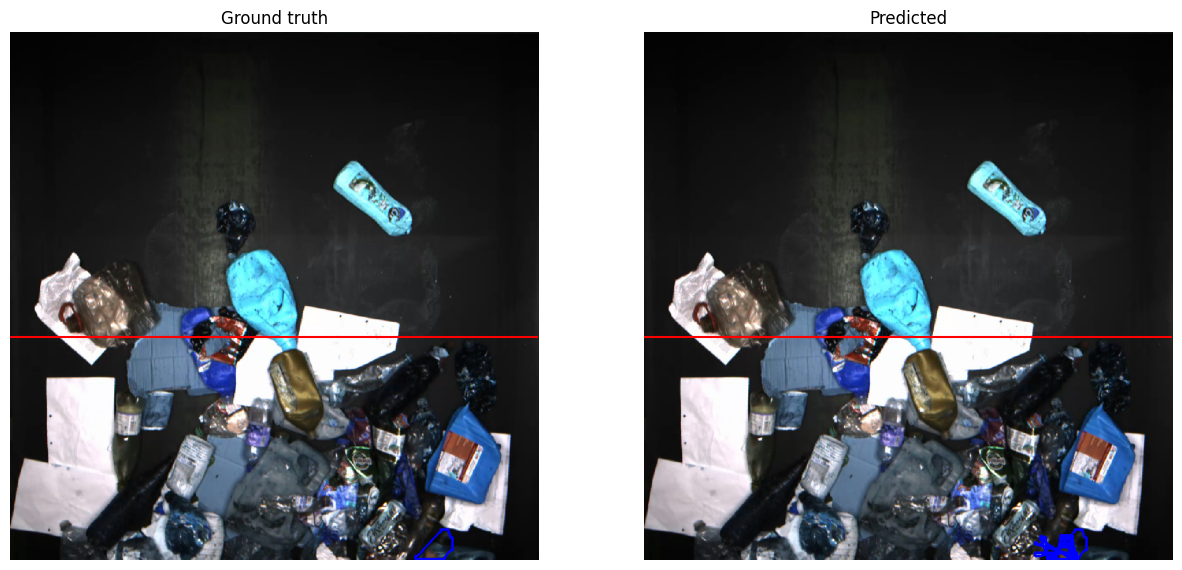

In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from utils.interpolate.markup_utils import vis_markup

for instance in pred_extended_groups[gidx][iidx:iidx+1]:
    print(instance['is_matched'], instance['is_border'], instance['img'])
    name = Path(instance['img']).name
    s = shifts[name] % 1000
    img = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs') / name)
    img = vis_markup(img, [instance['obj']])
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].set_title('Ground truth')
    axs[0].axis('off')
    axs[0].imshow(img)
    axs[0].axhline(y=img.shape[0]-s, color='r', linestyle='-')
    img_gt = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/dense_test/imgs') / name)
    img_gt = vis_markup(img_gt, [shift_mask(obj, -s) for obj in pred_groups[gidx]])
    axs[1].set_title('Predicted')
    axs[1].axis('off')
    axs[1].imshow(img_gt)
    axs[1].axhline(y=img_gt.shape[0]-s, color='r', linestyle='-')
    
    
iidx += 1
print(shifts[name])

plt.show()
gidx += 1
iidx = 0

In [ ]:
iidx = 0
gidx += 1

NameError: name 'gidx' is not defined

In [ ]:
gidx -= 1
gt_groups[gidx]

[{'cls': '1',
  'points': array([[     85.574,      1727.7],
         [     80.789,      1718.4],
         [     74.955,      1709.6],
         [     67.462,      1703.4],
         [     61.219,      1704.8],
         [     52.687,      1707.8],
         [     42.487,      1712.1],
         [     35.614,        1714],
         [     33.946,      1725.5],
         [     33.867,        1729],
         [     86.007,        1729],
         [     85.574,      1727.7]], dtype=float32),
  'count': 1},
 {'cls': '1',
  'points': array([[     98.761,        1775],
         [     97.023,      1763.2],
         [     95.155,      1748.8],
         [      89.53,      1738.2],
         [     85.574,      1726.7],
         [     80.789,      1717.4],
         [     74.955,      1708.6],
         [     67.462,      1702.4],
         [     61.219,      1703.8],
         [     52.687,      1706.8],
         [     42.487,      1711.1],
         [     35.614,        1713],
         [     33.946,      1724

In [ ]:
shifts

{'tula_sep_0002_2024_07_16_14_17_15_000.jpg': 60,
 'tula_sep_0002_2024_07_16_14_17_15_200.jpg': 120,
 'tula_sep_0002_2024_07_16_14_17_15_400.jpg': 180,
 'tula_sep_0002_2024_07_16_14_17_15_600.jpg': 240,
 'tula_sep_0002_2024_07_16_14_17_15_800.jpg': 301,
 'tula_sep_0002_2024_07_16_14_17_16_000.jpg': 362,
 'tula_sep_0002_2024_07_16_14_17_16_200.jpg': 422,
 'tula_sep_0002_2024_07_16_14_17_16_400.jpg': 483,
 'tula_sep_0002_2024_07_16_14_17_16_600.jpg': 545,
 'tula_sep_0002_2024_07_16_14_17_16_800.jpg': 606,
 'tula_sep_0002_2024_07_16_14_17_17_000.jpg': 668,
 'tula_sep_0002_2024_07_16_14_17_17_200.jpg': 729,
 'tula_sep_0002_2024_07_16_14_17_17_400.jpg': 789,
 'tula_sep_0002_2024_07_16_14_17_17_600.jpg': 851,
 'tula_sep_0002_2024_07_16_14_17_17_800.jpg': 912,
 'tula_sep_0002_2024_07_16_14_17_18_000.jpg': 974,
 'tula_sep_0002_2024_07_16_14_17_18_200.jpg': 1036,
 'tula_sep_0002_2024_07_16_14_17_18_400.jpg': 1097,
 'tula_sep_0002_2024_07_16_14_17_18_600.jpg': 1159,
 'tula_sep_0002_2024_07_16_14

In [ ]:
shifts['tula_sep_0002_2024_07_16_14_17_15_600.jpg']

240